In [1]:
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
from coffea import util
import hist
import mplhep
plt.style.use(mplhep.style.CMS)

In [2]:
out = util.load("outfiles/Run3Summer22EE/fulllumi/trigger_Run3Summer22EE_HLT_Mu50_ht.coffea")[0]

/tmp/ipykernel_89/4109681683.py:20: RuntimeWarning: invalid value encountered in divide
  efficiency = hist_data_after/hist_data_before


Text(0, 1, 'Trigger efficiency')

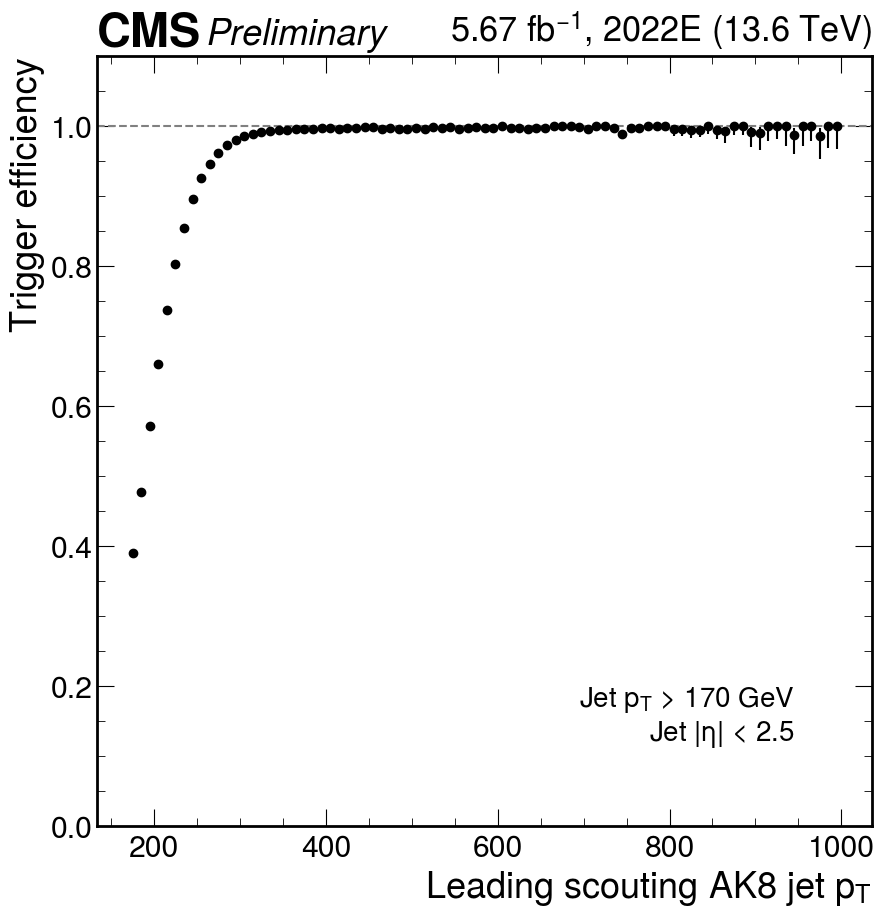

In [3]:
ptproj = (
    out["ak8"]
    .project("pt", "trigger")
)
denom = ptproj[:, hist.loc("none")]
num = ptproj[:, hist.loc("Run3_PFScoutingPixelTracking")]

hist_data_before, hist_bins = denom.to_numpy()
hist_data_after, hist_bins = num.to_numpy()

from scipy.stats import beta

def binom_int(num, den, confint=0.68):
    quant = (1 - confint)/ 2.
    low = beta.ppf(quant, num, den - num + 1)
    high = beta.ppf(1 - quant, num + 1, den - num)
    return (np.nan_to_num(low), np.where(np.isnan(high), 1, high))

# calculating efficiency
efficiency = hist_data_after/hist_data_before

# getting error band
band_low, band_high = binom_int(hist_data_after, hist_data_before)
error_low = efficiency - band_low
error_high = band_high - efficiency

# removing large errors in empty bins
error_low[error_low == 1] = 0
error_high[error_high == 1] = 0

# stacking errors
error = np.concatenate((error_low.reshape(error_low.shape[0], 1), error_high.reshape(error_high.shape[0], 1)), axis=1)

fig, ax = plt.subplots()

ax.errorbar(
                num.axes[0].centers,
                efficiency,
                yerr=error.T,
                color="black",
                marker="o",
                linestyle="none",
                #label="Data scouting"
            )

mplhep.cms.label(ax=ax, data=True, year="2022E", com=13.6, label="Preliminary", lumi=f"{5.672:.2f}",)
plt.text(0.9, 0.1, r"Jet p$_T$ > 170 GeV" + "\n" + r"Jet |$\eta$| < 2.5",
                fontsize=20,
                horizontalalignment='right',
                verticalalignment='bottom',
                transform=ax.transAxes
               )
ax.set_xlabel(r"Leading scouting AK8 jet p$_T$")
ax.set_ylim(0, 1.1)
ax.axhline(y=1, linestyle="--", color="gray")
ax.set_ylabel("Trigger efficiency")